## Setup

In [1]:
library(IRdisplay)
library(Cairo)

library(data.table)
library(arrow)
library(ggplot2)
library(cowplot)
library(ggrepel)
library(ggthemes)
library(ggpubr)
library(ggtext)
library(patchwork)
library(grid)
library(gridExtra)
library(scales)
library(stringr)
library(RColorBrewer)
library(yaml)
library(plyr)
library(tidyverse)
library(png)
library(rstatix)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map



Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots



Attaching package: ‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()      masks plyr::arrange()
✖ dplyr::between()      masks data.table::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ dplyr::combine()      masks gr

In [2]:
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res=200)

In [3]:
output_path = '/data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots'

In [4]:
# set global plot parameters
LINESIZE = 1
FONTSIZE = 12
THEME = theme_cowplot(font_size = FONTSIZE, font_family = 'Helvetica') + theme(plot.tag = element_text(face = "bold"))

In [5]:
eval_path = file.path('/s/project/promoter_prediction/kipoi_expression_prediction', 'evaluation/complete')
fname = paste0('prc_', 'tissue_type', '.parquet')
df = (file.path(eval_path, fname) %>%
      open_dataset(partitioning = c('run')) %>%
      as.data.table() %>%
      .[type_ == 'total'])
df = df[, .(tissue_type, run, score=auc)] %>% unique

In [6]:
fname = 'prc.parquet'
df1 = (file.path(eval_path, fname) %>%
      open_dataset(partitioning = c('run')) %>%
      as.data.table() %>%
      .[type_ == 'total'])

In [7]:
runs = list(
    all= c('aparent2_ensembl_deltapdui_wide',
           'aparent2_ensembl_deltapdui_narrow',
           'aparent2_ensembl_lor_wide',
           'aparent2_ensembl_lor_narrow'),
    upstream=c('aparent2_ensembl_deltapdui_wide_10_130',
               'aparent2_ensembl_deltapdui_wide_20_130',
               'aparent2_ensembl_deltapdui_wide_30_130',
               'aparent2_ensembl_deltapdui_wide_40_130',
               'aparent2_ensembl_deltapdui_wide_50_130',
               'aparent2_ensembl_deltapdui_wide_60_130',
               'aparent2_ensembl_deltapdui_wide_70_130'
    ),
    downstream=c('aparent2_ensembl_deltapdui_wide_70_10',
                 'aparent2_ensembl_deltapdui_wide_70_100',
                 'aparent2_ensembl_deltapdui_wide_70_110',
                 'aparent2_ensembl_deltapdui_wide_70_120',
                 'aparent2_ensembl_deltapdui_wide_70_130',
                 'aparent2_ensembl_deltapdui_wide_70_20',
                 'aparent2_ensembl_deltapdui_wide_70_30',
                 'aparent2_ensembl_deltapdui_wide_70_40',
                 'aparent2_ensembl_deltapdui_wide_70_50',
                 'aparent2_ensembl_deltapdui_wide_70_60',
                 'aparent2_ensembl_deltapdui_wide_70_70',
                 'aparent2_ensembl_deltapdui_wide_70_80',
                 'aparent2_ensembl_deltapdui_wide_70_90'
)
    )

In [8]:
superscript_mapping = c(
    `-` = '⁻',
    `+` = "", # ⁺
    `0` = "\u2070",
    `1` = "\u00B9",
    `2` = "\u00B2",
    `3` = "\u00B3",
    `4` = "\u2074",
    `5` = "\u2075",
    `6` = "\u2076",
    `7` = "\u2077",
    `8` = "\u2078",
    `9` = "\u2079"
)


In [9]:
fancy_scientific <- function(l, digits=NULL, low=1/1000, high=1000) {
    # turn in to character string in scientific notation
    l = as.numeric(l)
    if (is.na(l)) {
        return("NA")
    }
    if (l == 0) {
        return("0")
    }
    if ((low < l) & (l < high)){
        return(format(l, scientific=FALSE, digits=digits, big.mark=",", trim=TRUE))
    }
    l = format(l, scientific=TRUE, digits=digits)

    # l <- format(l, scientific = TRUE)
    # split into factor and exponent
    l_split = strsplit(l, 'e')[[1]]
    if (! is.null(digits)) {
        l_split[1] = round(as.numeric(l_split[1]), digits)
    }
    # make exponent superscript
    l_split[2] = as.numeric(l_split[2])
    l_split[2] = paste(
        lapply(strsplit(l_split[2], "")[[1]], function(x) noquote(superscript_mapping[[x]])),
        collapse=''
    )
    # concat everything
    l_split = paste0(l_split[1], "x10", l_split[2])

    l_split
}


In [10]:
prc_plot = function(df, title){
    return (
        ggplot(df[is_binary == FALSE,], aes(x=`recall`, y=`precision`))
        + geom_step(aes(color = `run`), linewidth=LINESIZE, direction="hv")
        + THEME
        + background_grid(major = "xy", minor = "xy")
        + scale_x_continuous(
            # limits = c(0, 0.35),
            breaks = seq(0, 1, 0.1),
            minor_breaks = seq(0, 1, 0.2)
        )
        + scale_y_continuous(
            # limits = c(-0.0, 0.3),
            breaks = seq(0, 1, 0.05),
            minor_breaks = seq(0, 1, 0.2)
            # breaks = seq(0, 1, 0.05),
            # minor_breaks = seq(0, 1, 0.025)
        )
        + guides(color=guide_legend(order = 1))
        + theme(
            #legend.position="right",
            legend.position = c(0.95, 0.95),
            legend.justification = c("right", "top"),
            legend.margin=margin(-15,15,2,2),
            legend.background=element_rect(fill='white', color='black', linewidth=0.3)
            # axis.text.x=element_text(angle=45, hjust=1),
        )
        + labs(
            x='Recall',
            y='Precision',
            title=title,
            color=''
        )
        + coord_cartesian(ylim=c(-0.0, 0.3), xlim=c(-0.0, 0.1))
    )
}

In [11]:
boxplot_plot = function(df, title, ylim=NULL, is_y_percent=FALSE, pval_y_start=NULL, pval_y_end=NULL, show_pval=TRUE){
    df = copy(df)
    run_keys = levels(df$run)
    # find best run
    df[, median_score := median(score), by='run']
    df = df[order(-median_score)]
    # change order of run levels
    new_levels = df$run %>% unique %>% rev
    df[, run := factor(run, levels=new_levels)]
    best_run = df[1, run]

    # Wilcoxon test between best run and everything else
    comparisons = lapply(setdiff(run_keys, best_run), function(x) c(as.character(best_run), as.character(x)))

    stat.test <- (
        df
        %>% wilcox_test(`score` ~ `run`, paired=TRUE, comparisons=comparisons) 
        %>% add_significance("p")
    )
    

    # Add p-values to a boxplot
    stat.test <- stat.test %>% add_xy_position(x = "run") %>% arrange(xmin)
    stat.test$p_label = paste0(ifelse(stat.test$statistic == 0, "P < ", "P = "), lapply(stat.test$p, function(x) fancy_scientific(x, 1)))                     
    # print(as.data.table(stat.test))

    if (!is.null(pval_y_start) & !is.null(pval_y_end)){
        n = nrow(stat.test)
        stat.test$y.position = seq(pval_y_start, pval_y_end, length.out = n)
    }
    # print(as.data.table(stat.test))

    stat_label=if (show_pval) 'p_label' else 'p.signif'                                                                                    
                                                                                        
    p <- (
        ggplot(df, aes(y=`score`, x=`run`))
        + coord_flip(clip='off')
        + geom_boxplot(fill='grey')
        + scale_y_continuous(
            limits=if (is.null(ylim)) c(0, max(df[['score']]) * 2) else ylim,
            labels=if (is_y_percent) scales::percent else waiver()
        )
        + THEME
        + background_grid(major = "y")
        + theme(legend.title = element_blank())
        + theme(legend.position = "none")
        + labs(
            y=element_blank(),
            x=element_blank(),
        )
        + stat_pvalue_manual(stat.test, label = paste0('{', stat_label,'}'), coord.flip=TRUE)
        + background_grid()
    )
                                                                                    
                                                                                        
    return(p)
}                                                                                        

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <b5>”


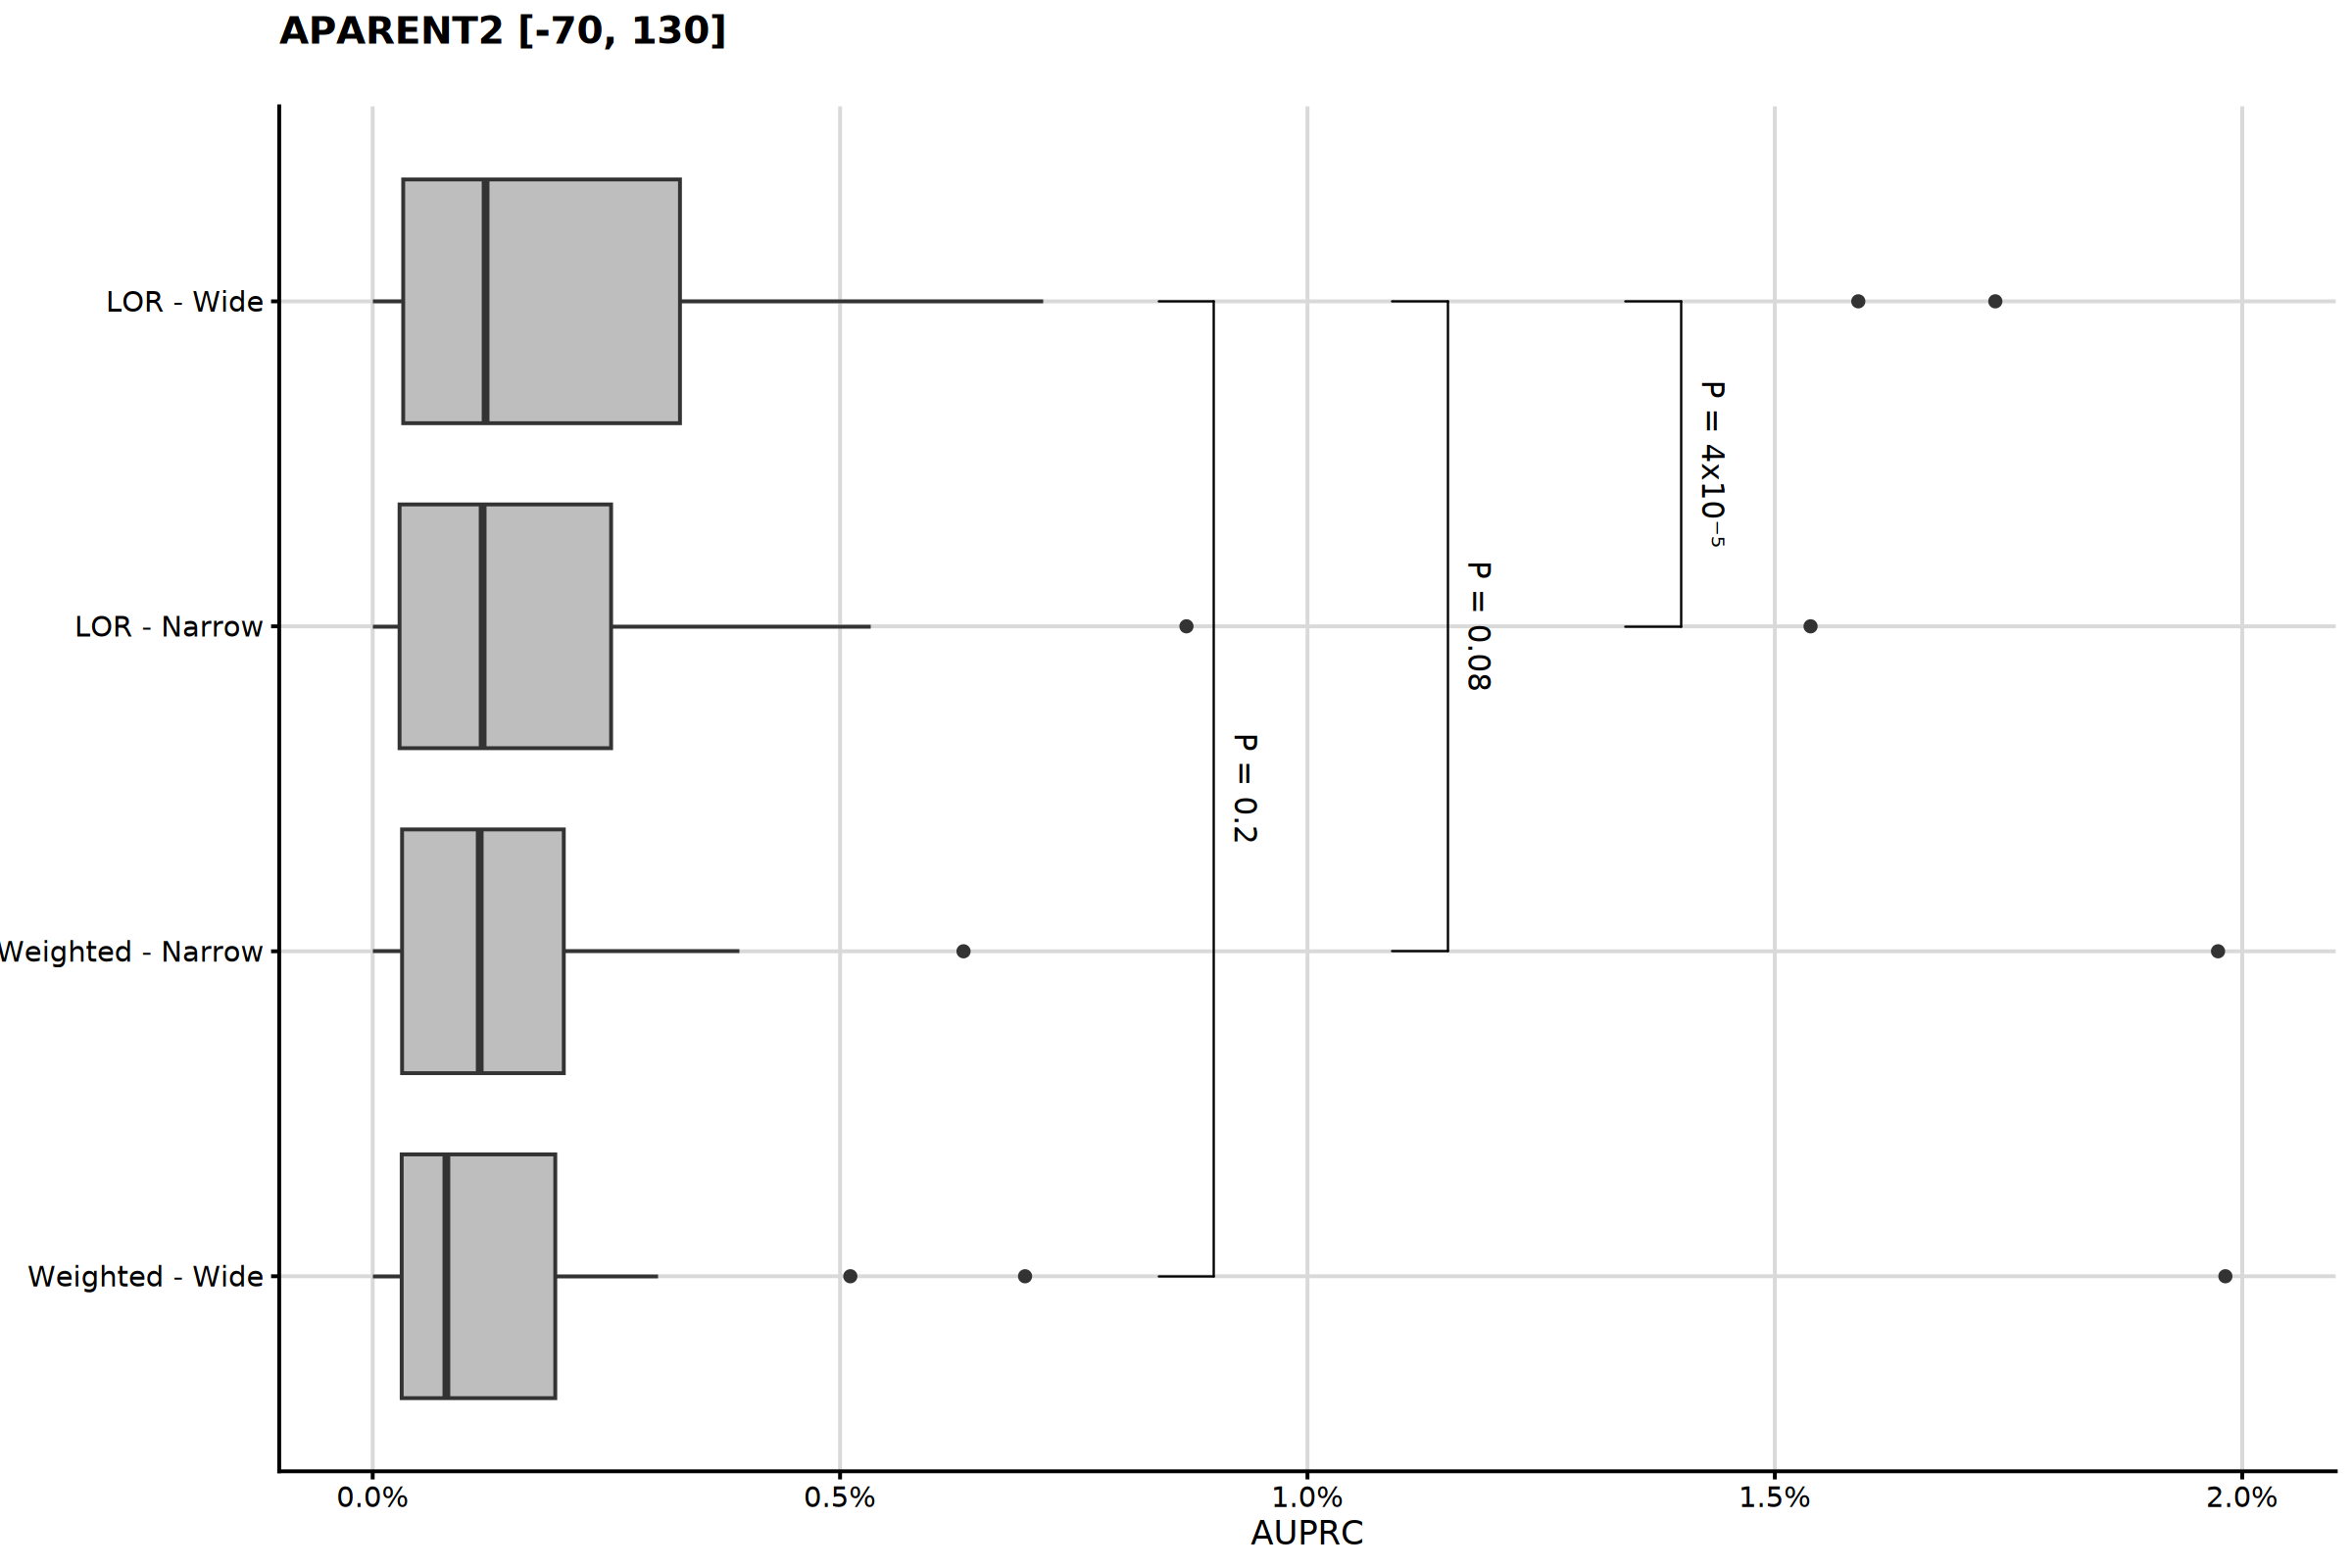

In [35]:
main_df = df[run %in% runs[['all']]] %>%
    .[, run := run %>% 
      str_replace('aparent2_ensembl_deltapdui_wide', 'Weighted - Wide') %>%
      str_replace('aparent2_ensembl_lor_narrow', 'LOR - Narrow') %>%
      str_replace('aparent2_ensembl_lor_wide', 'LOR - Wide') %>%
      str_replace('aparent2_ensembl_deltapdui_narrow', 'Weighted - Narrow')
     ]
main_df = main_df[, run := as.factor(run)]

p1 <- boxplot_plot(main_df, is_y_percent=TRUE,  pval_y_start=0.009, pval_y_end=0.014, ylim=c(0, 0.02)) + 
    labs(title='APARENT2 [-70, 130]', y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)))
p1

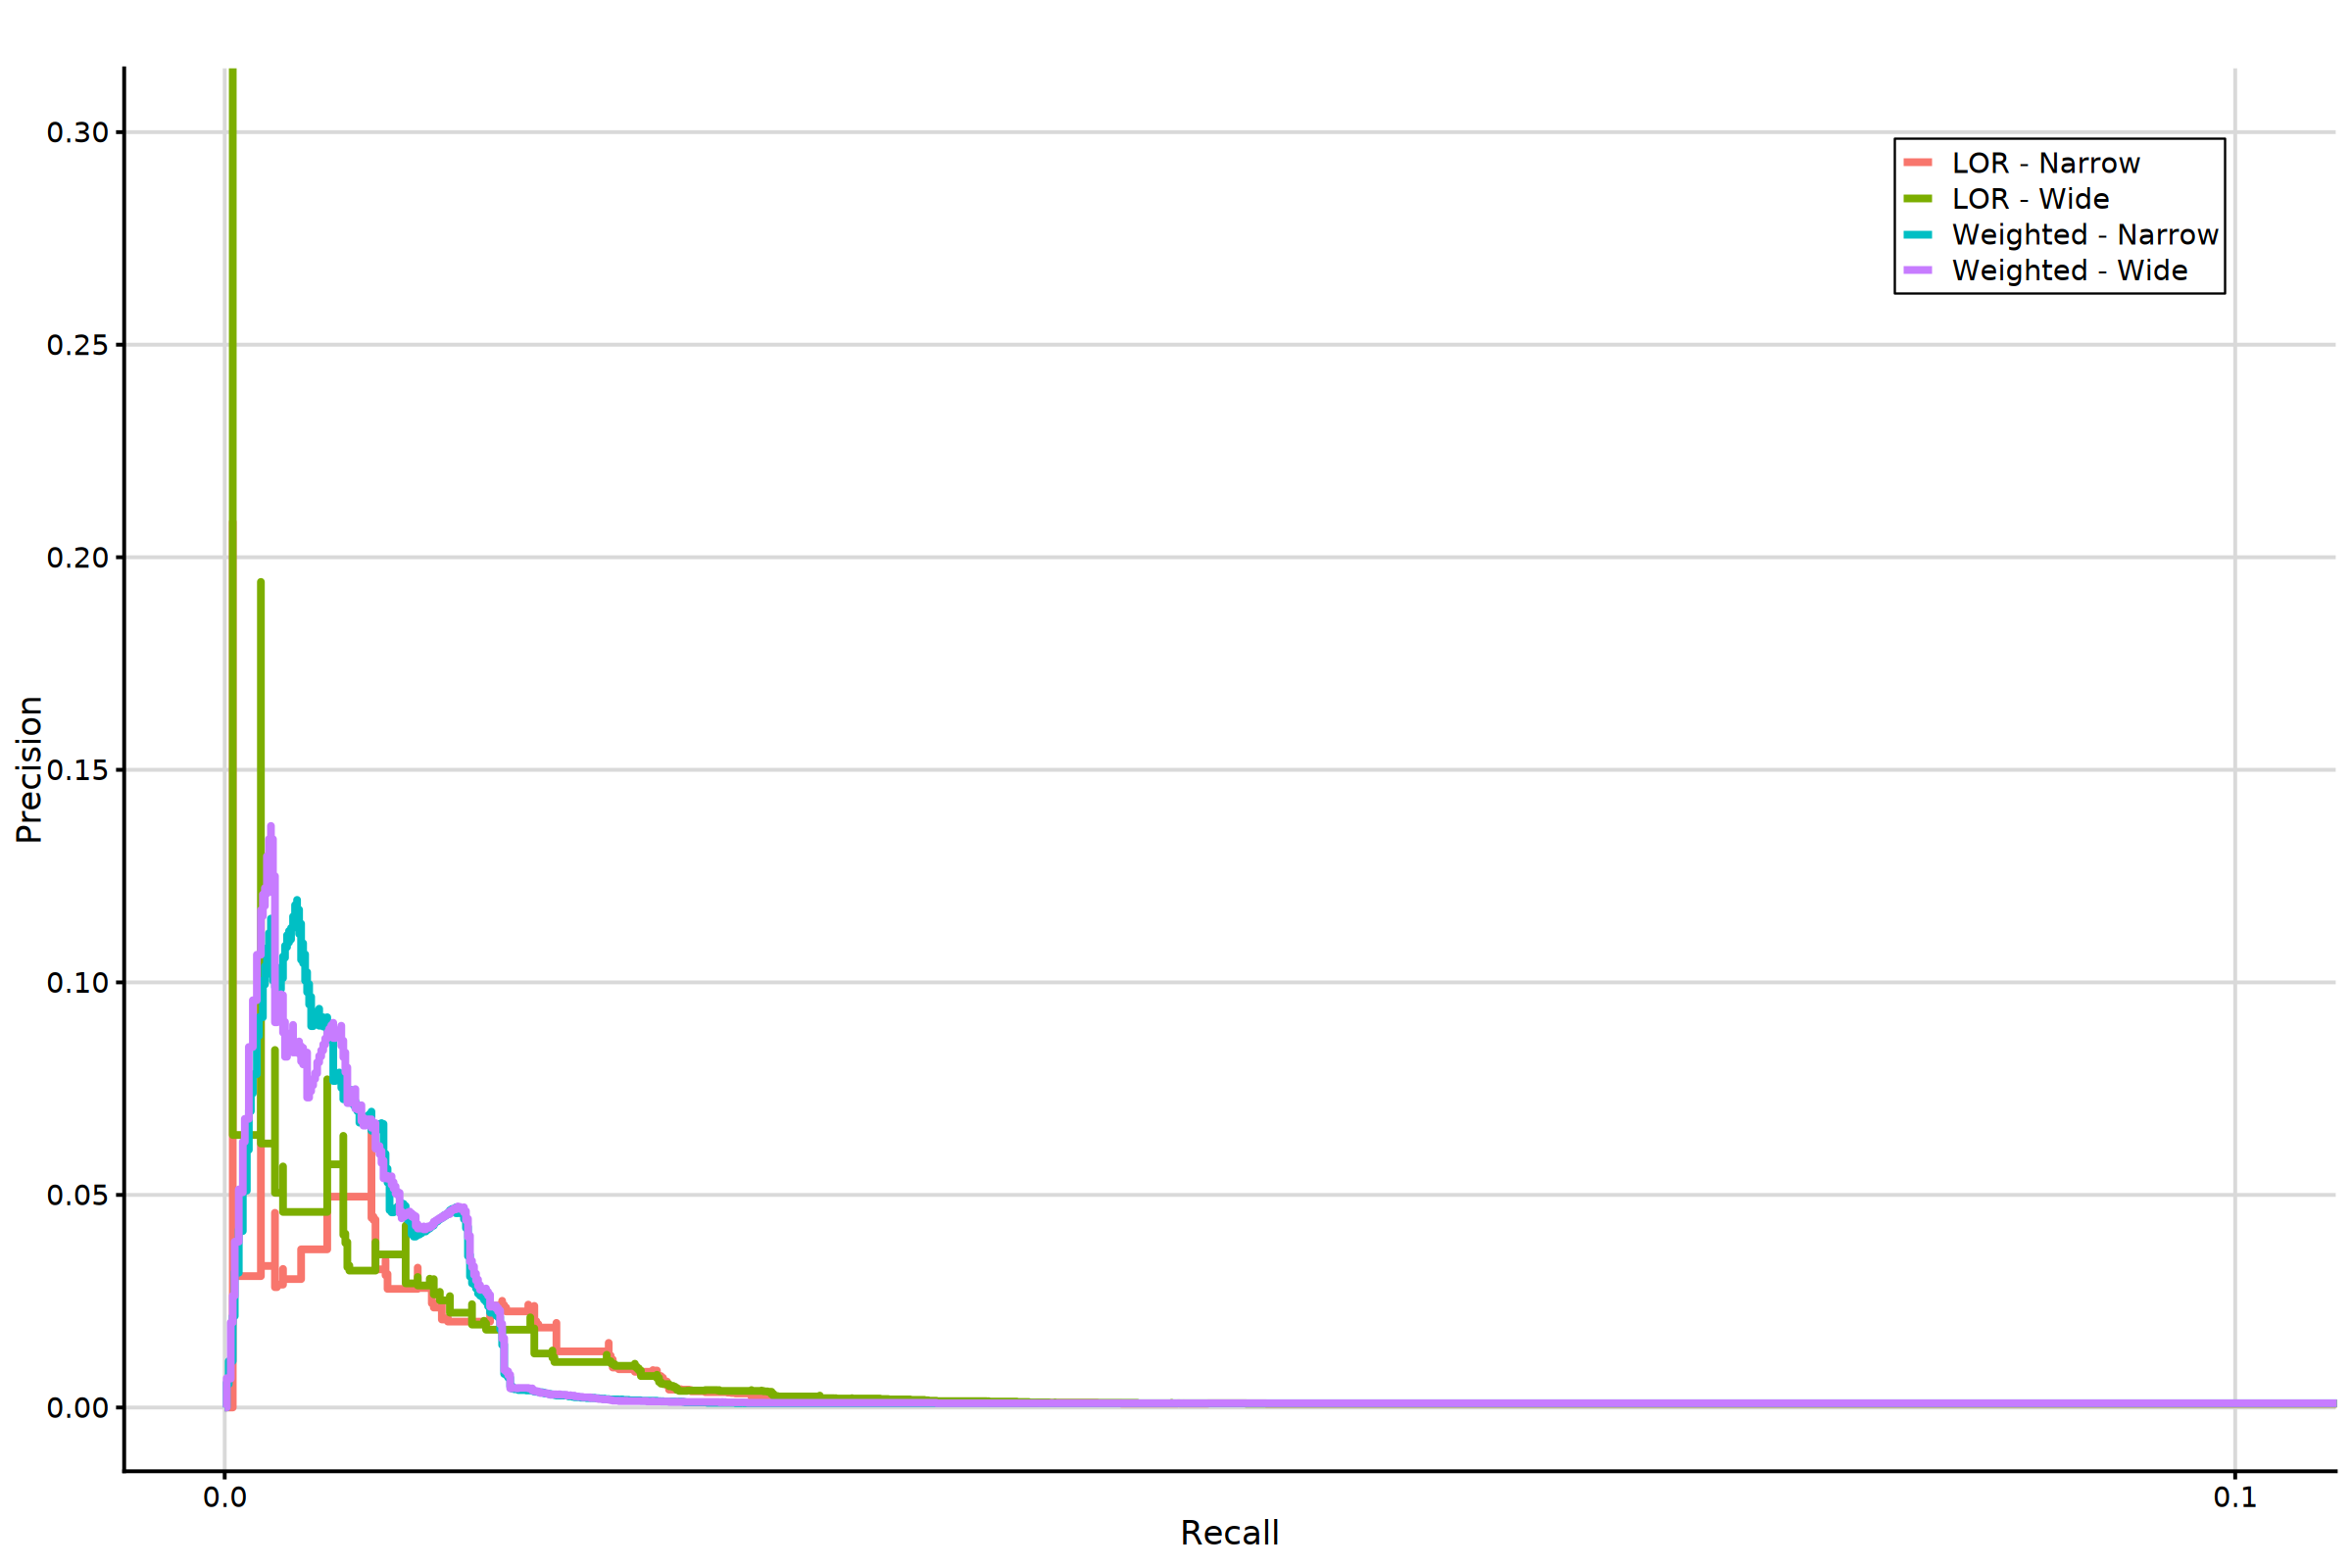

In [36]:
main_df1 = df1[run %in% runs[['all']]] %>%
    .[, run := run %>% 
      str_replace('aparent2_ensembl_deltapdui_wide', 'Weighted - Wide') %>%
      str_replace('aparent2_ensembl_lor_narrow', 'LOR - Narrow') %>%
      str_replace('aparent2_ensembl_lor_wide', 'LOR - Wide') %>%
      str_replace('aparent2_ensembl_deltapdui_narrow', 'Weighted - Narrow')
     ]
p2 = prc_plot(copy(main_df1), title='')
p2

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁵' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁵' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁵' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁵' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁵' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 2x10⁻⁵' in 'mbcsToSbcs': dot substituted for <b5>”
Warning message 

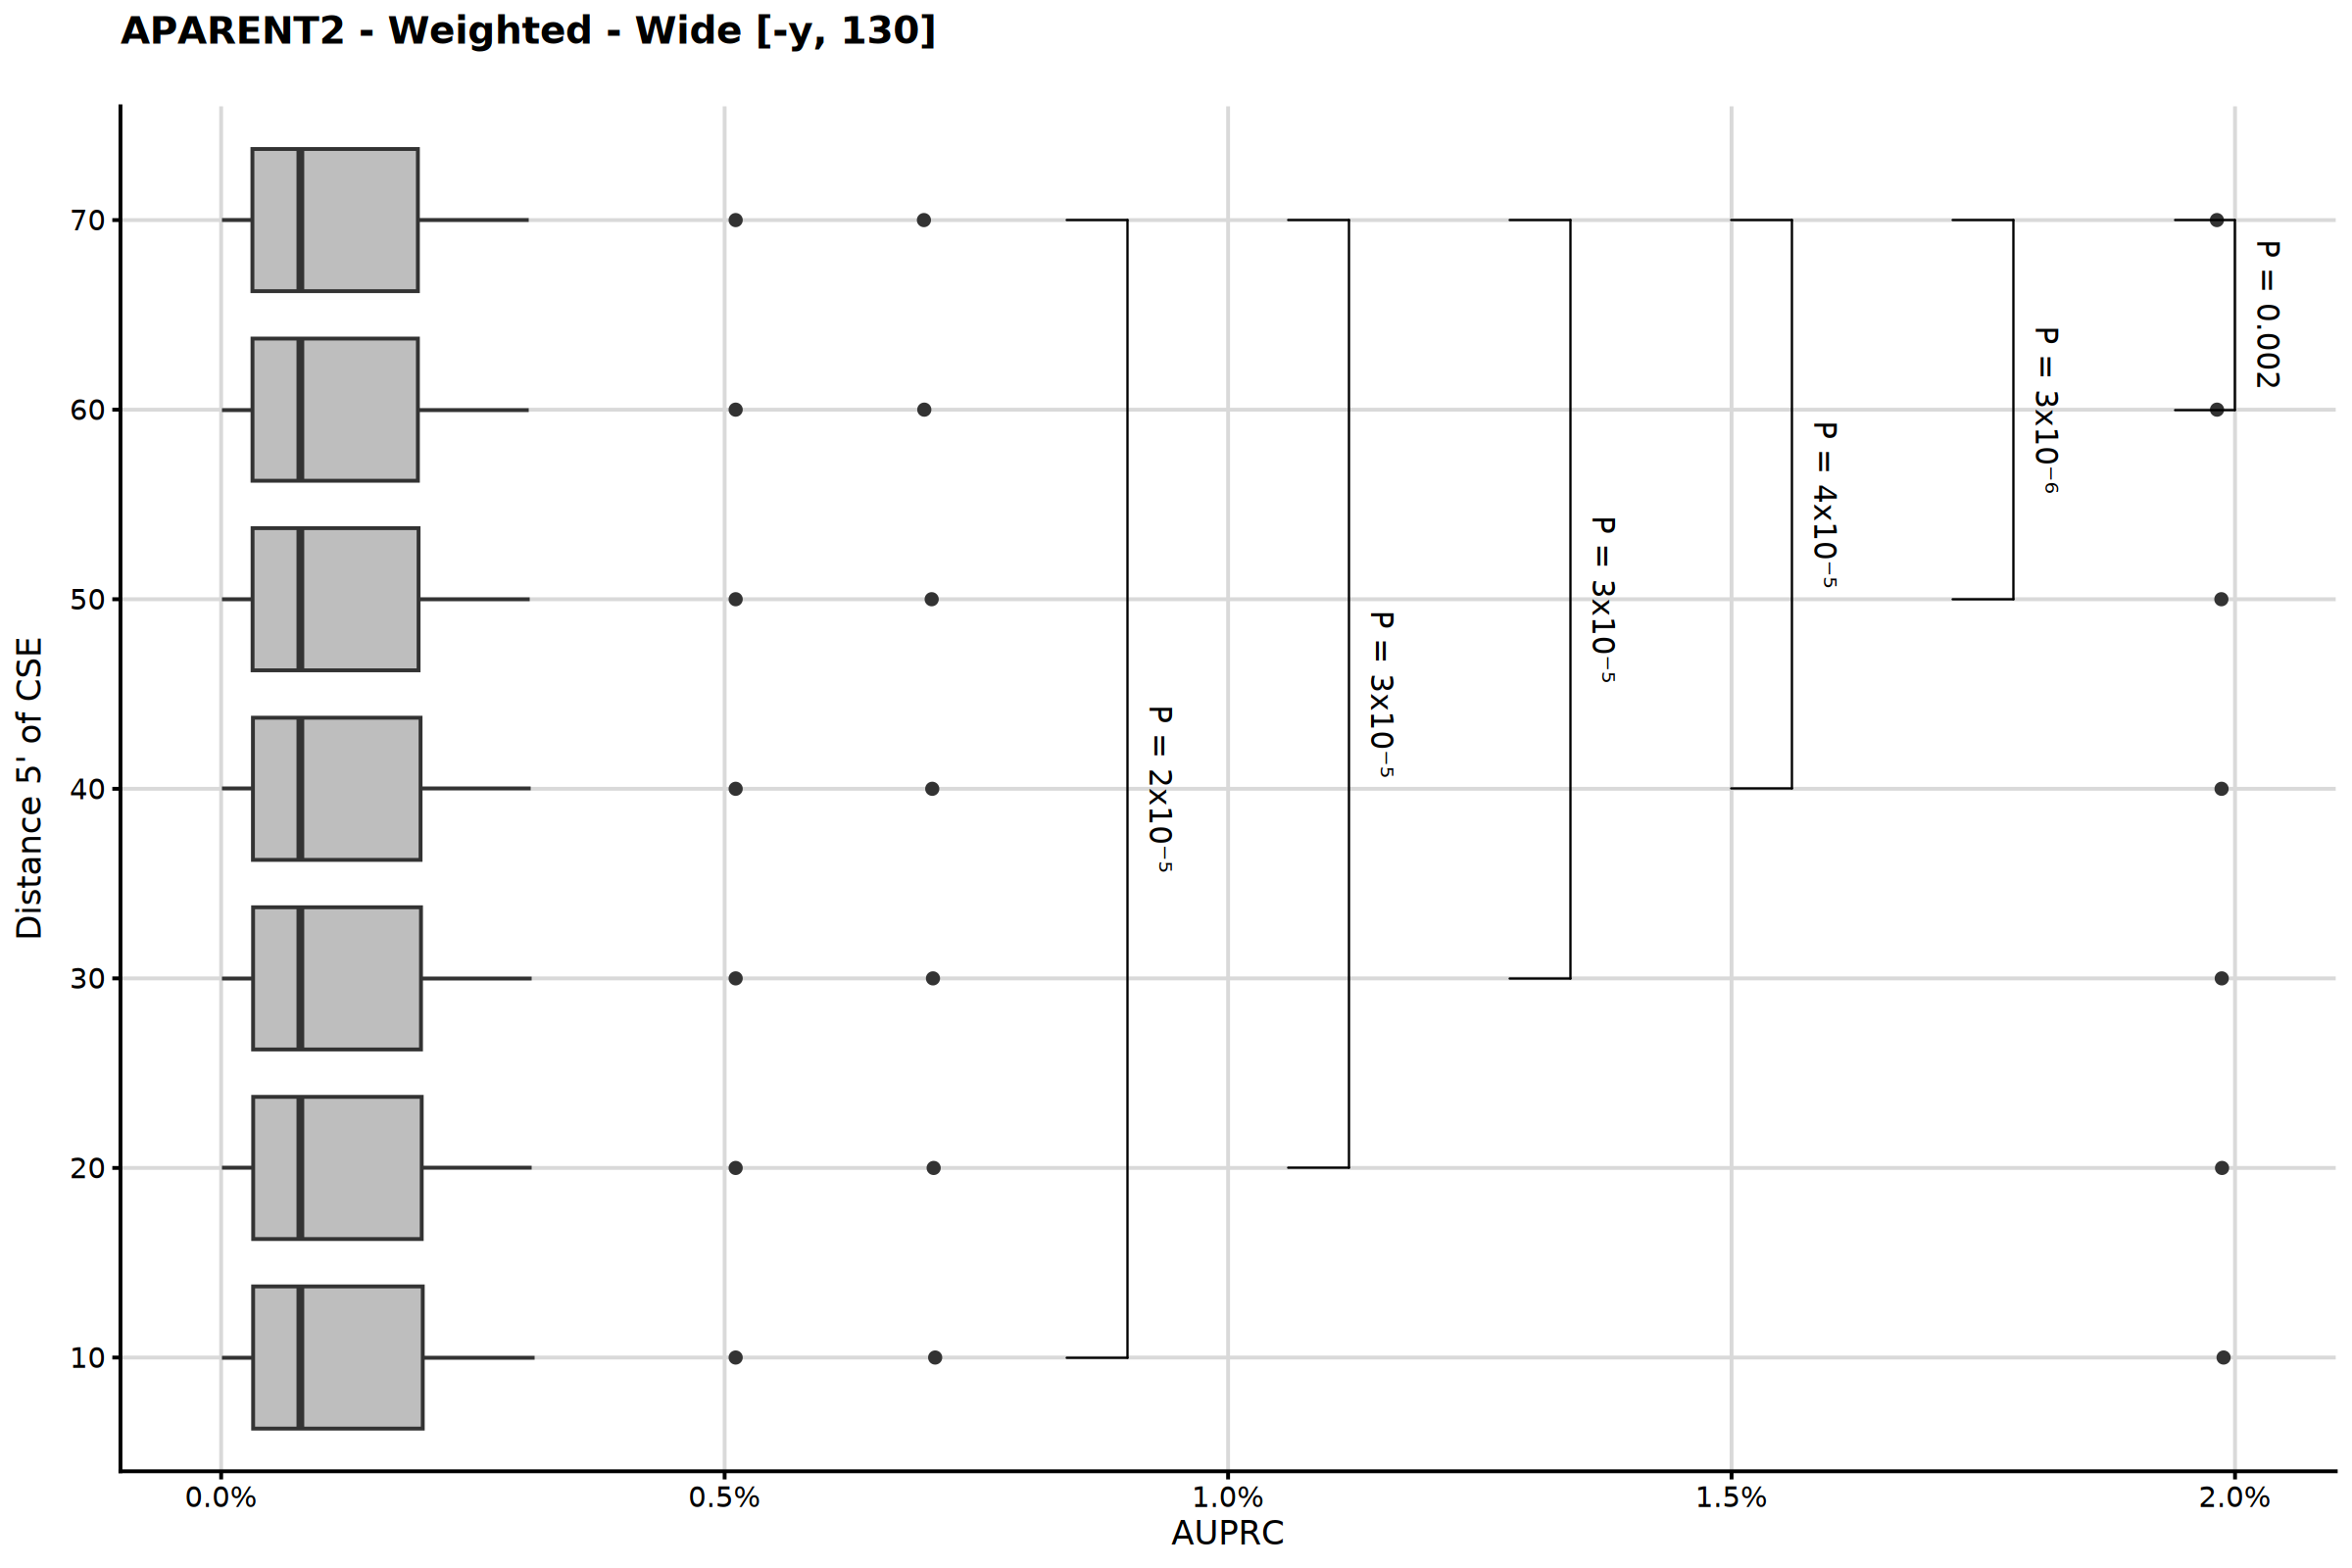

In [37]:
upstream_df = df[run %in% runs[['upstream']]] %>%
    .[, run := run %>% 
      str_replace('aparent2_ensembl_deltapdui_wide_', '') %>%
      str_replace('_130', '')
     ]
upstream_df = upstream_df[, run := as.factor(run)]

p3 <- boxplot_plot(upstream_df, is_y_percent=TRUE, pval_y_start=0.009, pval_y_end=0.02, ylim=c(0, 0.02)) + 
    labs(title= 'APARENT2 - Weighted - Wide [-y, 130]',
         x="Distance 5' of CSE", y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)),
          axis.title.y = element_text(margin = margin(0,10,0,0)))
# +
#     theme(plot.title = element_text(margin = margin(0,0,20,0)))
p3

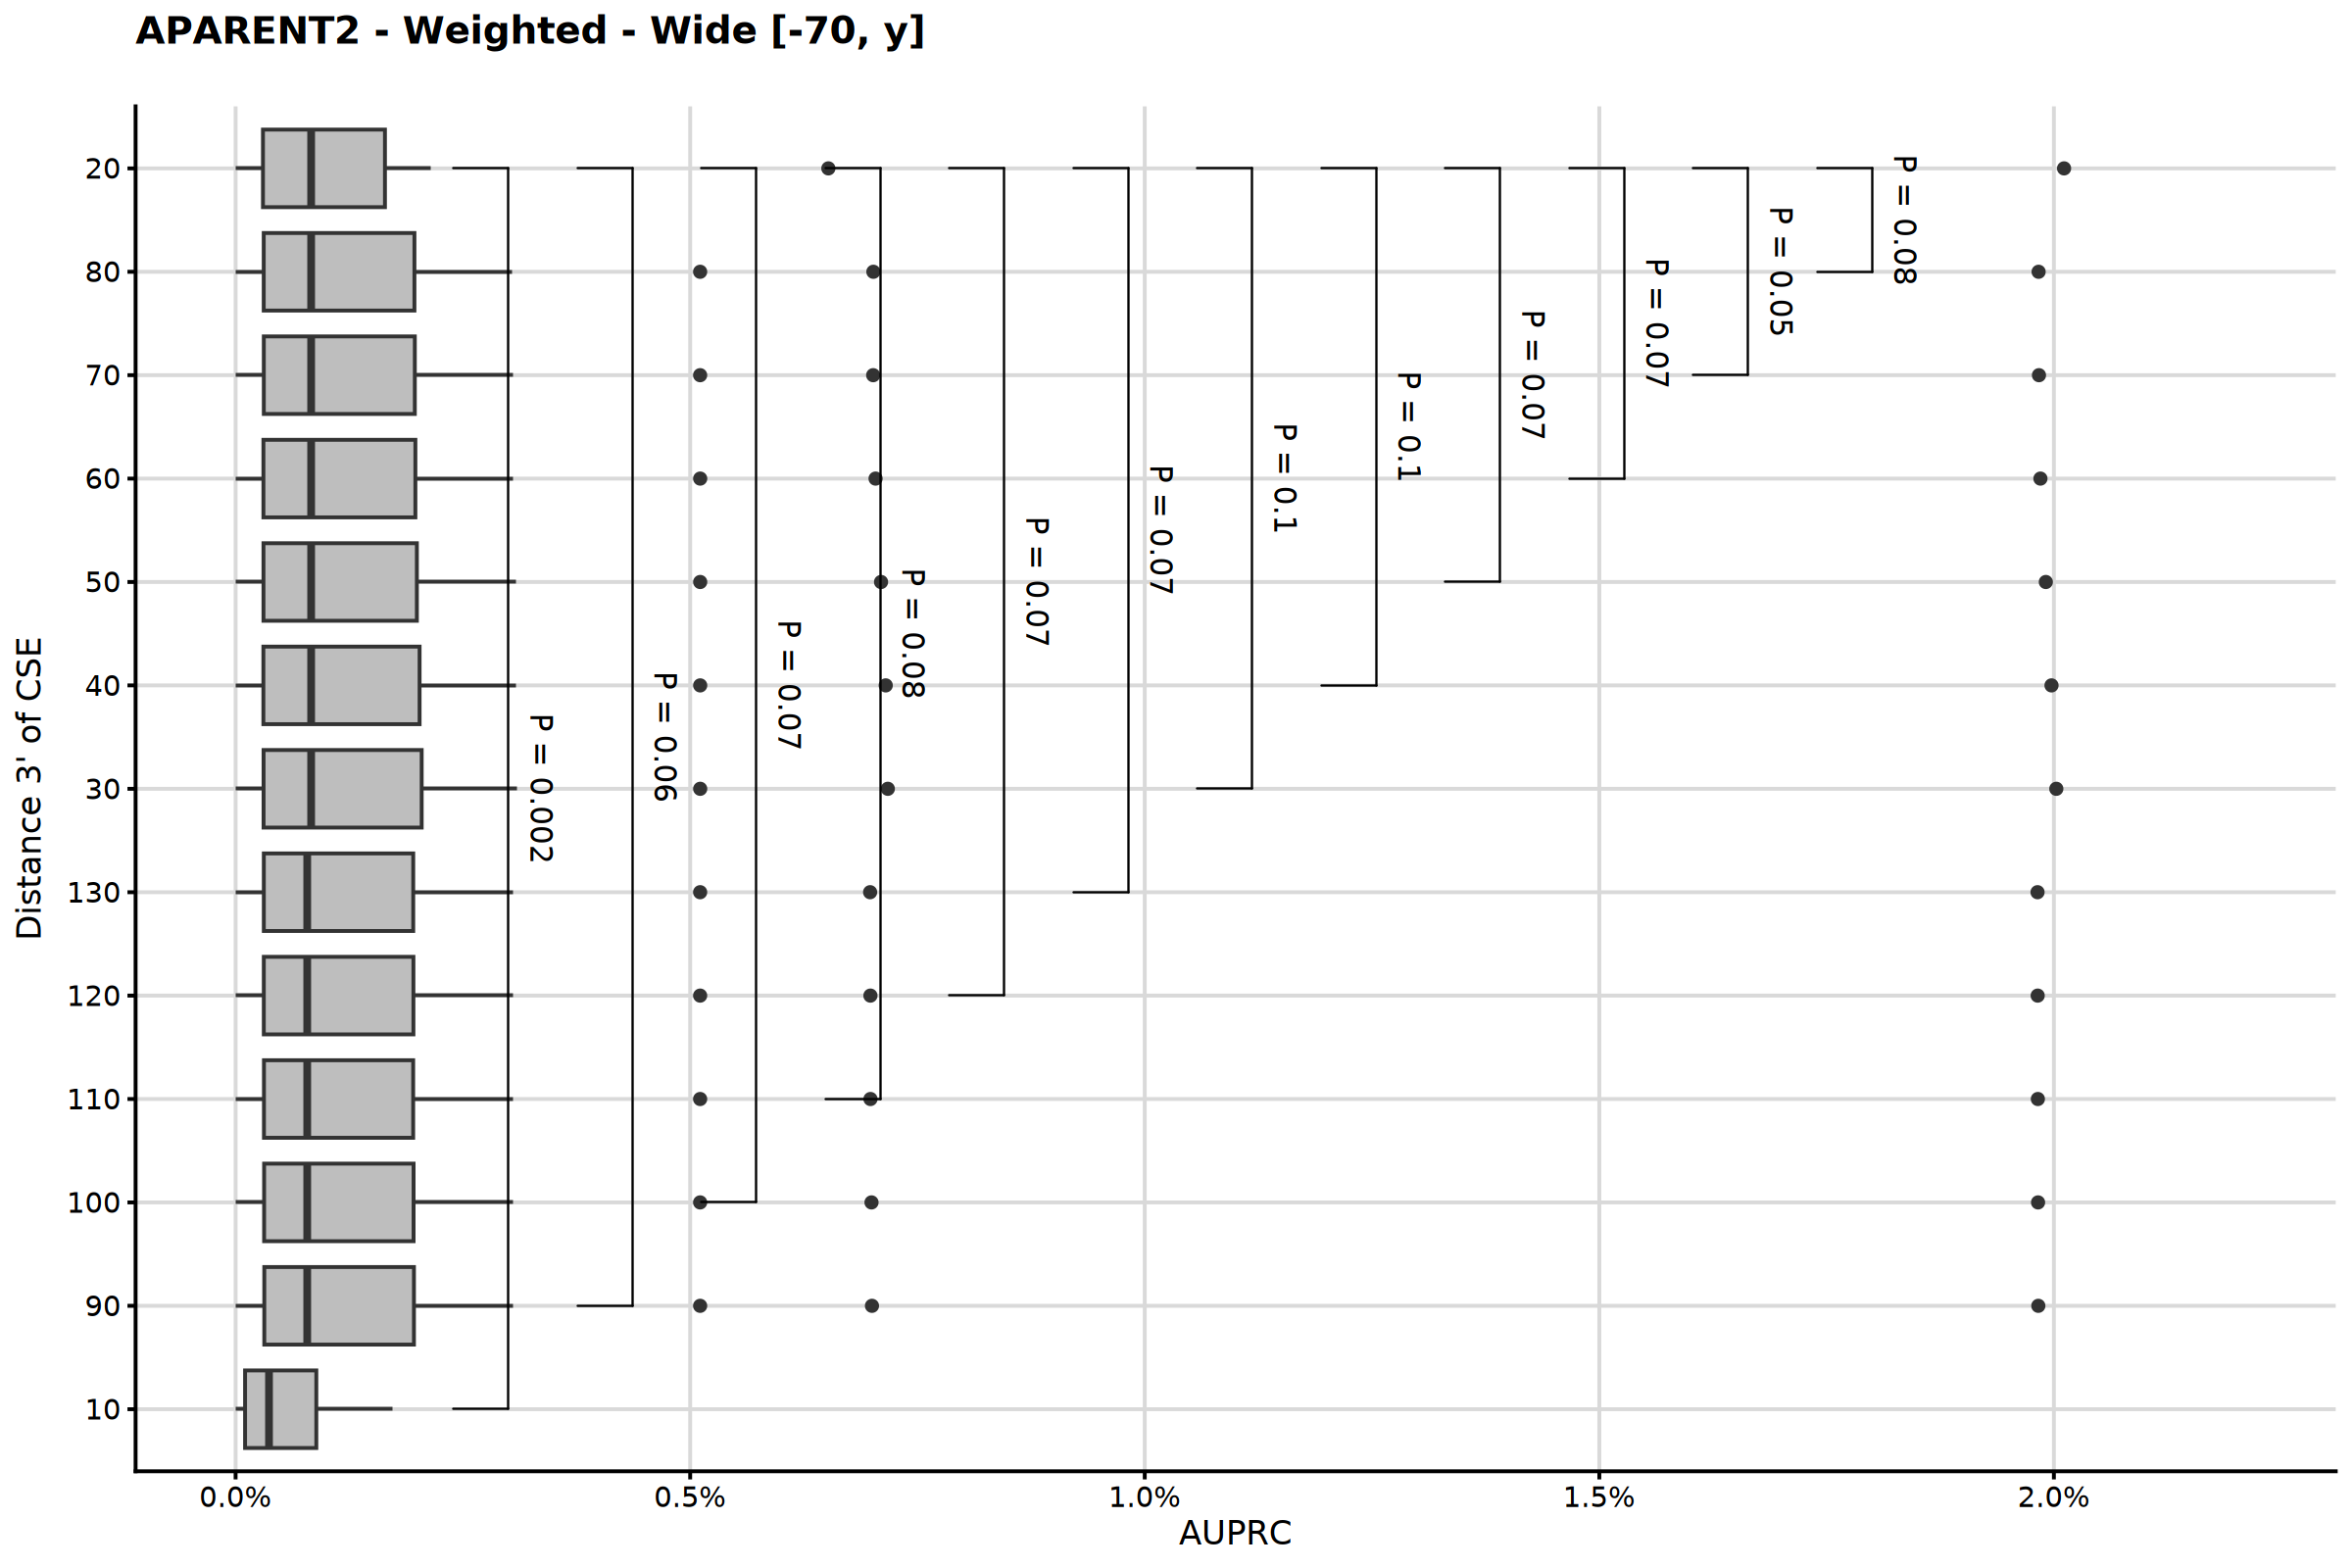

In [38]:
downstream_df = df[run %in% runs[['downstream']]] %>%
    .[, run := run %>% 
      str_replace('aparent2_ensembl_deltapdui_wide_', '') %>%
      str_replace('70_', '')
     ]
downstream_df = downstream_df[, run := as.factor(run)]

p4 <- boxplot_plot(downstream_df, is_y_percent=TRUE, pval_y_start=0.003, pval_y_end=0.018, ylim=c(0, 0.022)) + 
    labs(title='APARENT2 - Weighted - Wide [-70, y]',
         x="Distance 3' of CSE", y='AUPRC') +
    theme(plot.title = element_text(margin = margin(0,0,20,0)),
          axis.title.y = element_text(margin = margin(0,10,0,0)))
p4

In [39]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.res=200)

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <bb>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <81>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'P = 4x10⁻⁵' in 'mbcsToSbcs': dot substituted for <b5>”
Warning message 

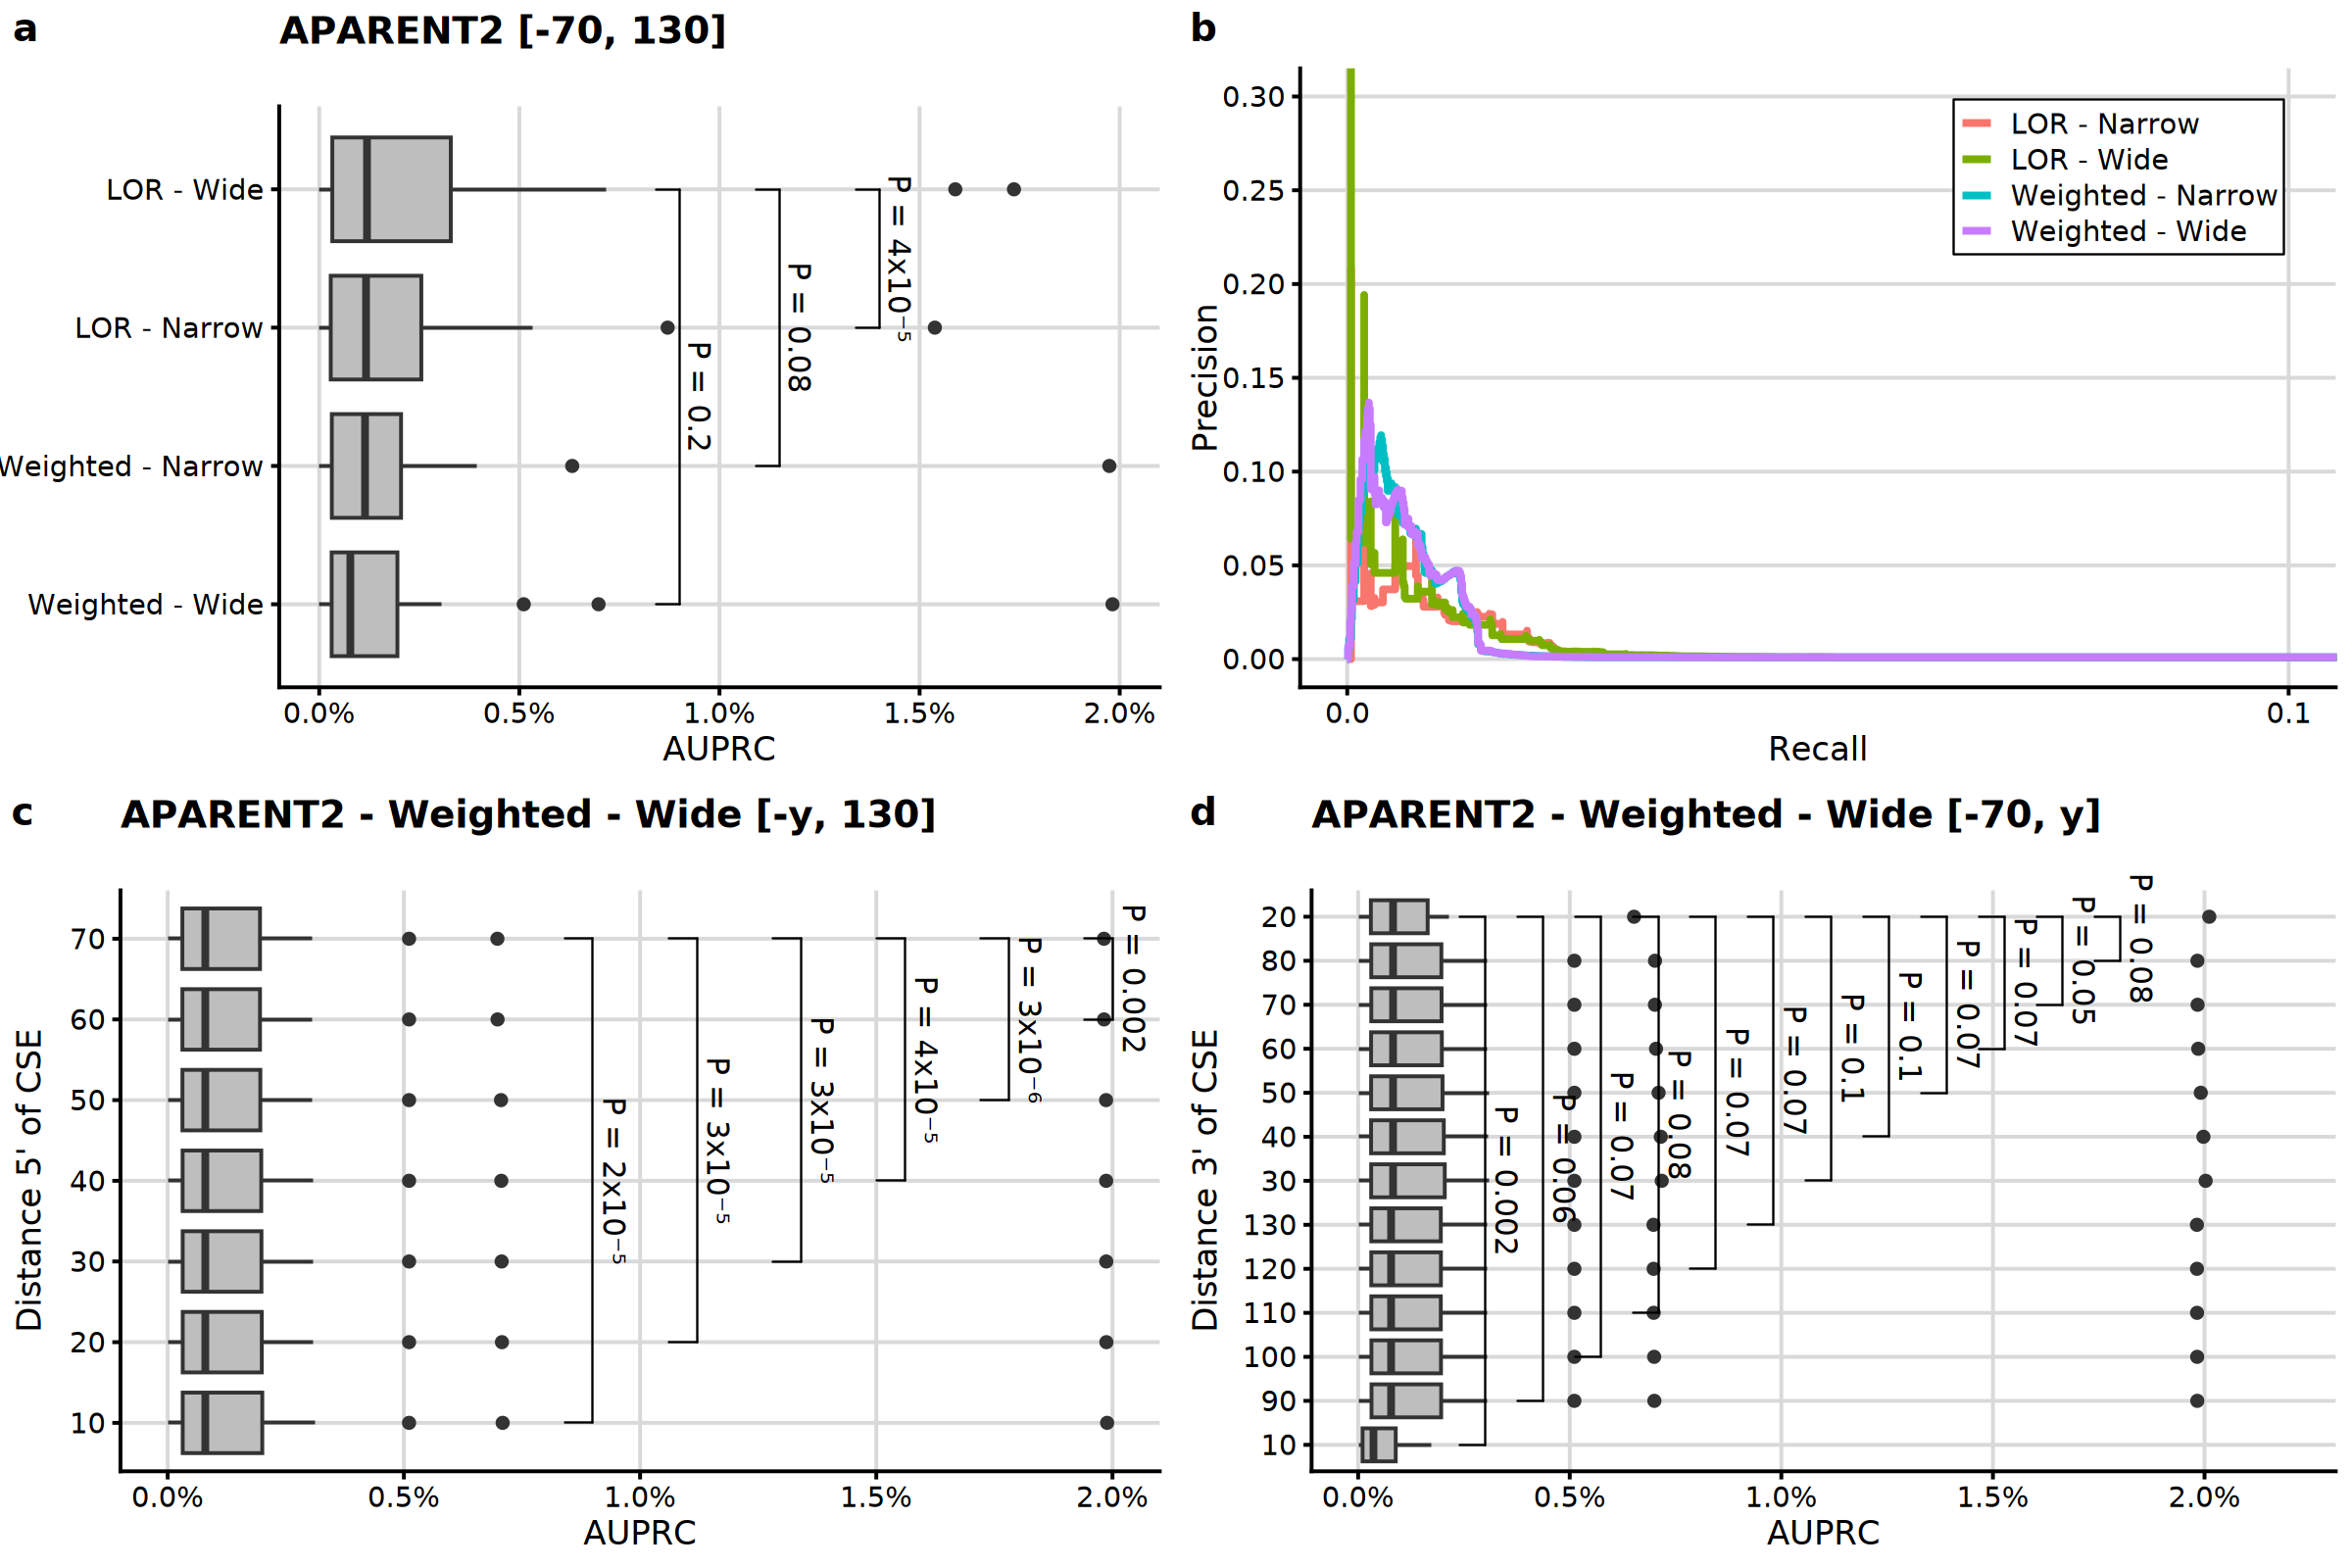

In [40]:
p5 = plot_grid(p1, p2, p3, p4, labels = c('a', 'b', 'c', 'd'))
p5

[1] "Saving to /data/nasif12/home_if12/tsi/projects/kipoi_veff_analysis/plots/aparent2_optimization..."


Warning message:
“Using ragg device as default. Ignoring `type` and `antialias` arguments”


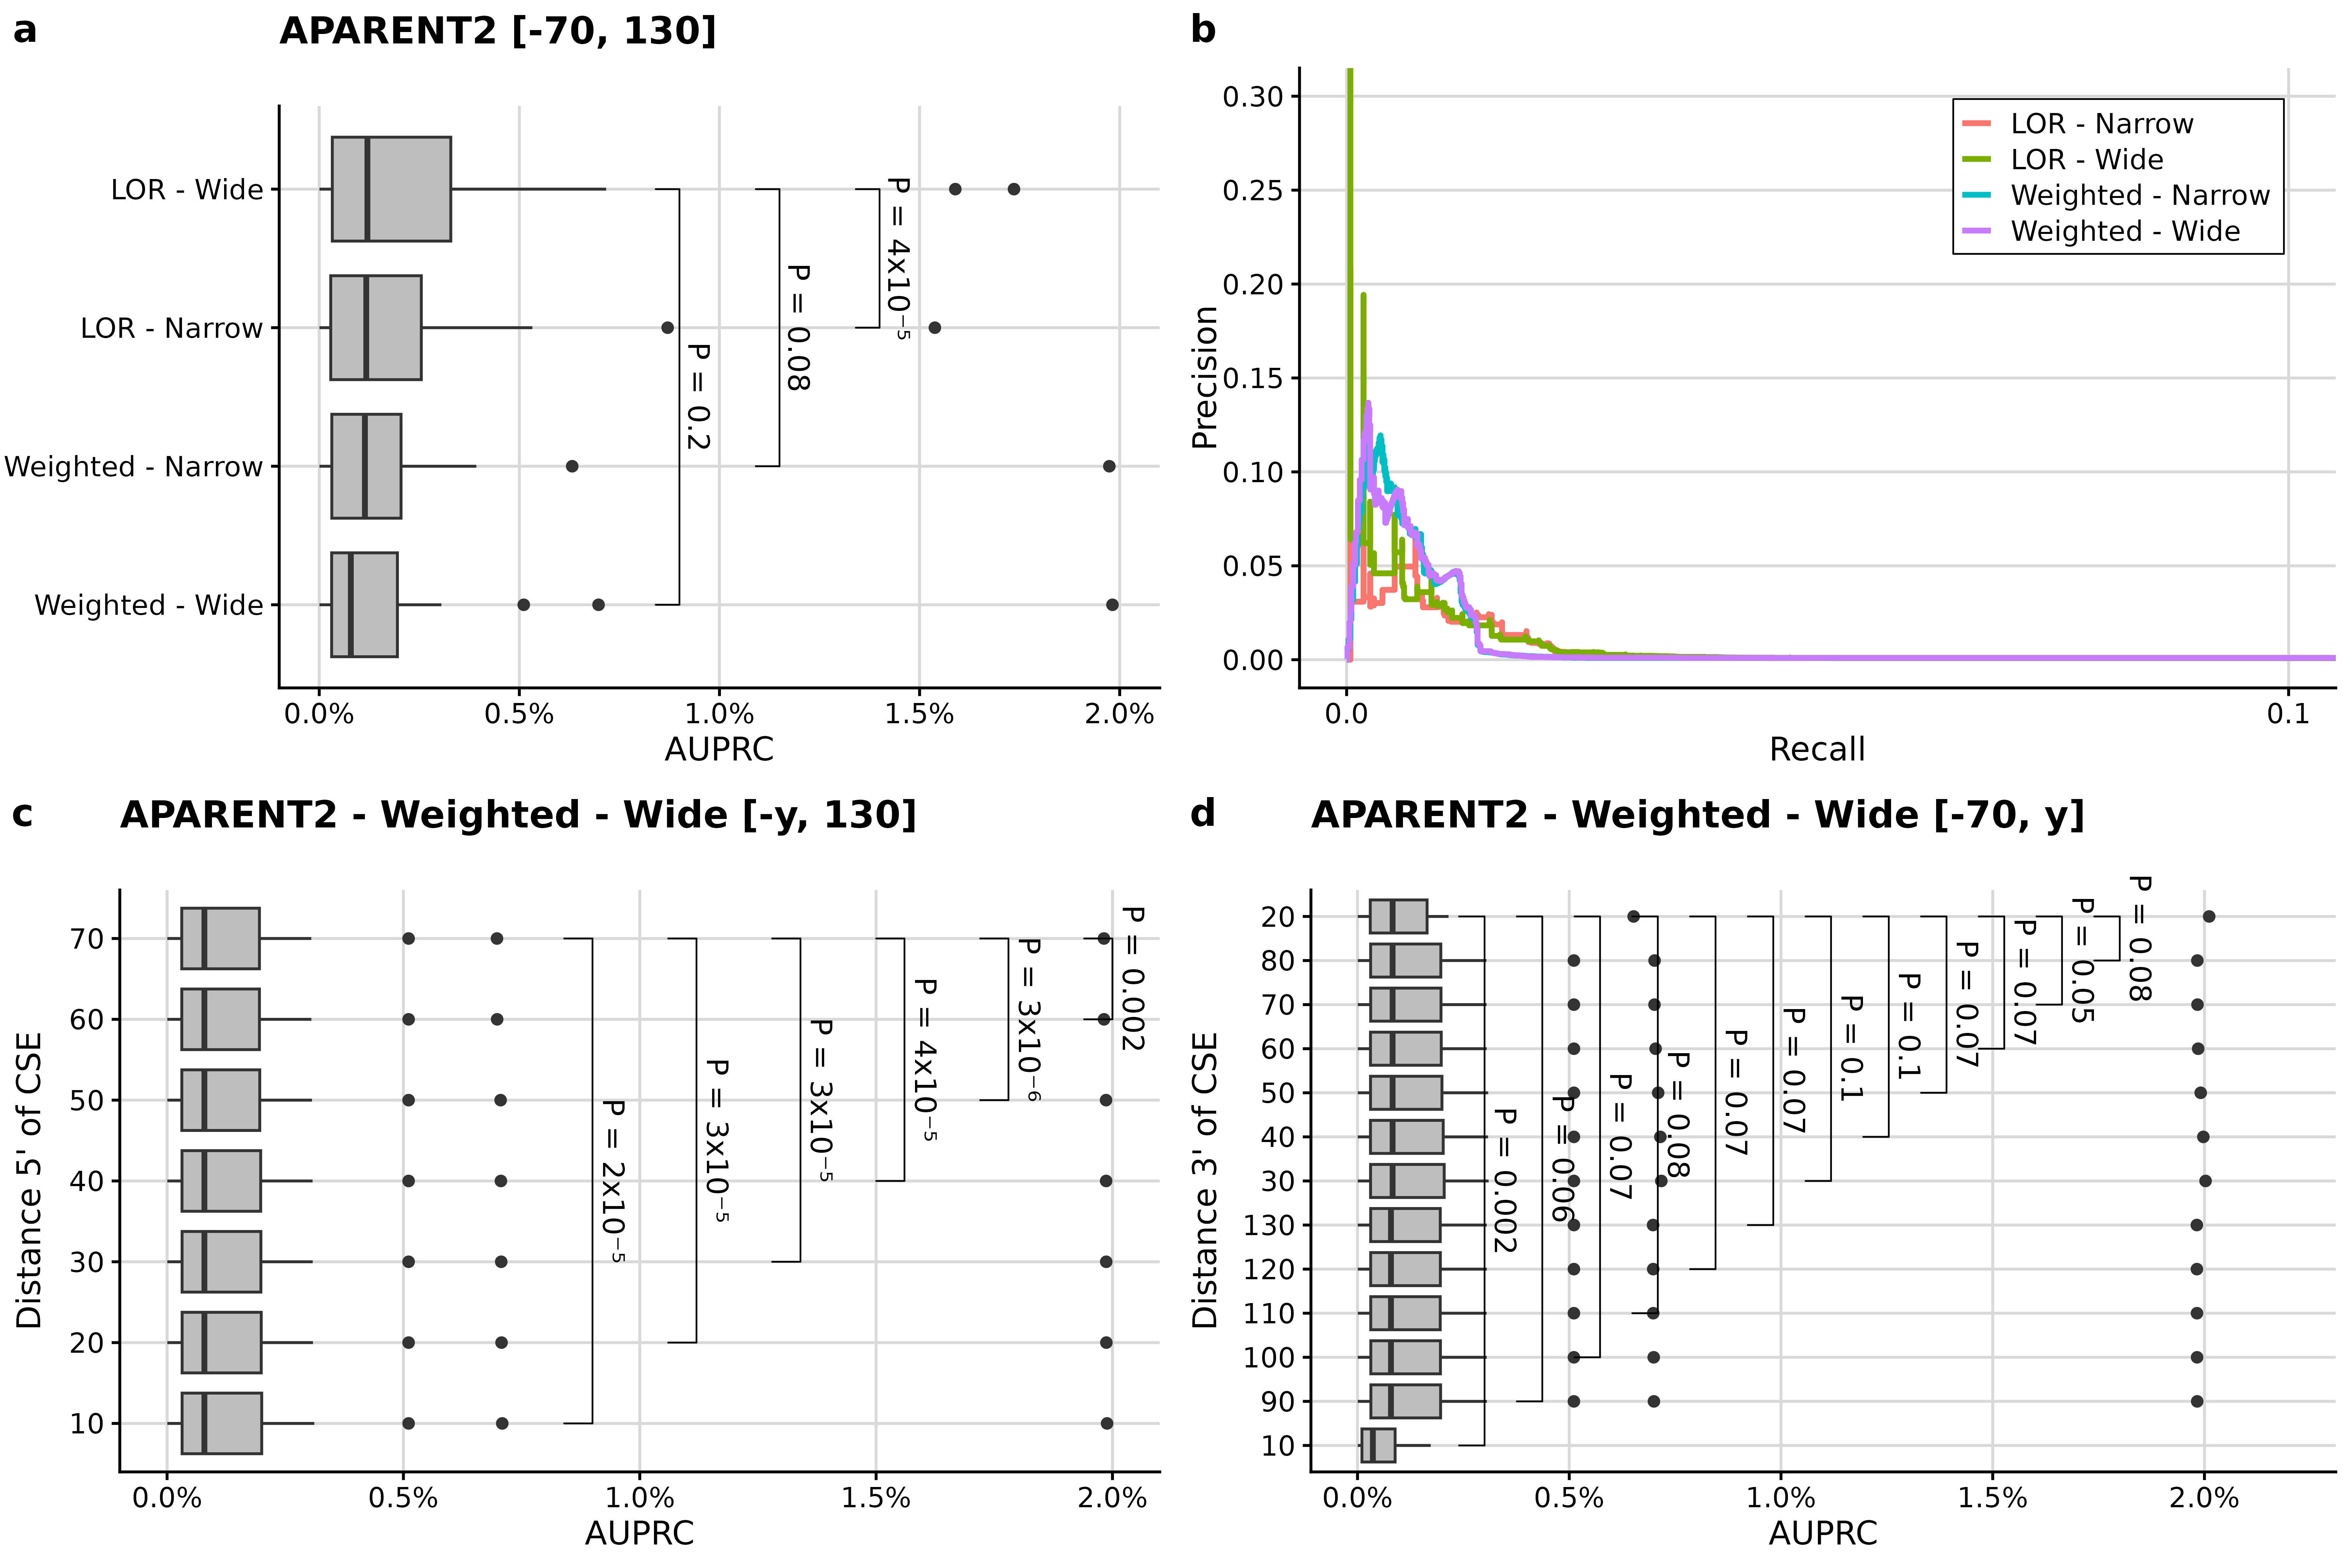

In [41]:
width=12
height=8

path = paste(output_path, 'aparent2_optimization', sep='/')
print(paste0("Saving to ", path, "..."))
ggsave(paste0(path, ".png"), bg = 'white', p5, width = width, height = height, dpi=600, type = "cairo")

display_png(file=paste0(path, ".png"))